# IMDb Database Clean Up

I downloaded IMDb Non-Commercial Datasets from this link: https://developer.imdb.com/non-commercial-datasets/

In this notebook I will do EDA and clean up to prepare the data for SQL.

In [1]:
import gzip
import pandas as pd
import pickle
import requests

f = open("token_TMDB.txt","r")
token = f.read()
headers = {"accept": "application/json", "Authorization": f"Bearer {token}"}

In [2]:
# File paths for the zipped IMDb Database files

file_paths = ['name.basics.tsv.gz',
              'title.basics.tsv.gz',
              'title.principals.tsv.gz',
              'title.crew.tsv.gz',
              'title.ratings.tsv.gz']


In [ ]:
# Creating pickle files for zipped files for efficiency

for item in file_paths:

    file_name = item[:-7]  # Remove the '.tsv.gz' part
    print(file_name)
    
    # Open the gzip-compressed TSV file and read it as a DataFrame
    with gzip.open(item, 'rt', encoding='utf-8') as f:
        df = pd.read_table(f, sep='\t', low_memory=False, na_values=["\\N", "nan"])

    # Save the DataFrame as a pickle file
    with open(file_name + '.pkl', 'wb') as f:
        pickle.dump(df, f)


## Cleaning Movies Dataset

title.basics.tsv.gz file contains the following information for titles:

- tconst (string) - alphanumeric unique identifier of the title.
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc).
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release.
- originalTitle (string) - original title, in the original language.
- isAdult (boolean) - 0: non-adult title; 1: adult title.
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year.
- endYear (YYYY) – TV Series end year. "\N" for all other title types.
- runtimeMinutes – primary runtime of the title, in minutes.
- genres (string array) – includes up to three genres associated with the title.

I only need movies so I will need to filter the movies from this dataframe. I will then check for NaN values and either drop them or fill them out using TMDB API if needed. I will also drop the unnecessary columns.

In [3]:
# Creating movies DataFrame with title.basics file
movies = pickle.load(open('title.basics.pkl', 'rb'))

In [4]:
# Filtering movies DataFrame to keep only the rows where the 'titleType' column has the value 'movie'.
movies = movies[movies['titleType']== 'movie']

In [5]:
# I do not need titleType and endYear columns because all the rows are movies and endYear column is null for movies. 
movies.drop(columns=['titleType','endYear'], inplace=True)

In [6]:
movies.shape

(677726, 7)

### Dealing with NaN values

I will check the null values in the DataFrame. Since my DataFrame is already really big, I will drop the rows with null values. 

In [7]:
movies.isna().sum()

tconst                 0
primaryTitle           2
originalTitle          2
isAdult                0
startYear          98020
runtimeMinutes    251367
genres             74742
dtype: int64

In [8]:
# There are only 2 movies without a title. Let's see if there is a bug there. 
movies[movies['primaryTitle'].isna()]

,tconst,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
4554578,tt17042812,NaN,NaN,0.0,2010.0,87,Thriller
8820526,tt5774076,NaN,NaN,0.0,2015.0,NaN,"Action,Drama,Mystery"


In [9]:
# Title of these movies is 'None' so I change the titles accordingly. 
movies.loc[movies['primaryTitle'].isna(), ['primaryTitle', 'originalTitle']] = 'None'

In [10]:
movies[movies[['startYear', 'runtimeMinutes', 'genres']].isna().any(axis=1)]

,tconst,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
498,tt0000502,Bohemios,Bohemios,0.0,1905.0,100,NaN
610,tt0000615,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,NaN,Drama
625,tt0000630,Hamlet,Amleto,0.0,1908.0,NaN,Drama
668,tt0000675,Don Quijote,Don Quijote,0.0,1908.0,NaN,Drama
828,tt0000838,A Cultura do Cacau,A Cultura do Cacau,0.0,1909.0,NaN,NaN
...,...,...,...,...,...,...,...
10702444,tt9916178,Yesterday's Dreams,Yesterday's Dreams,0.0,NaN,NaN,NaN
10702448,tt9916188,Minotaur,Minotaur,0.0,NaN,NaN,Thriller
10702565,tt9916428,The Secret of China,Hong xing zhao yao Zhong guo,0.0,2019.0,NaN,"Adventure,History,War"
10702657,tt9916620,The Copeland Case,The Copeland Case,0.0,NaN,NaN,Drama


Production year, movie duration and genre informations are primordial for my recommender.
I tried using API to fill out the missing info but I have had 2 main issues: 

1. The information needed is not available for the most of the rows on TMDB API. 
2. It takes a lot of time to retrieve this data

So I have decided to proceed by dropping those rows. If it is not on IMDB, I will assume that it is not important. 

In [11]:
movies.dropna(subset=['startYear', 'runtimeMinutes', 'genres'], how='any', inplace=True)

### Checking Data Types

In [12]:
movies.dtypes

tconst             object
primaryTitle       object
originalTitle      object
isAdult           float64
startYear         float64
runtimeMinutes     object
genres             object
dtype: object

I change data type for isAdult to boolean, startYear and runtimeMinutes to integer.

In [13]:
movies['startYear'] = movies['startYear'].astype(int)
movies['runtimeMinutes'] = movies['runtimeMinutes'].astype(int)
movies['isAdult'] = movies['isAdult'].astype(bool)

In [14]:
# I don't want my recommender to recommend adult content.
movies = movies[movies['isAdult']==False]
movies.drop(columns=['isAdult'], inplace=True)

In [15]:
movies = movies[(movies['runtimeMinutes'] >= 60) & (movies['runtimeMinutes'] <= 240)]
# I want my recommender to recommend movies of regular runtime duration. 

In [16]:
movies = movies[(movies['startYear'] <= 2024) & (movies['startYear'] >= 1940)]
# I want my recommender to recommend movies produced after 1940 for relevancy 
# and I eliminate the movies that hasn't been released yet. 

In [17]:
movies

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
13079,tt0013274,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,2021,94,Documentary
15482,tt0015724,Dama de noche,Dama de noche,1993,102,"Drama,Mystery,Romance"
18590,tt0018867,Escape from Hong Kong,Escape from Hong Kong,1942,60,"Adventure,Mystery,War"
21706,tt0022064,Lebbra bianca,Lebbra bianca,1951,80,Drama
23705,tt0024121,Houkutuslintu,Houkutuslintu,1946,84,Drama
...,...,...,...,...,...,...
10702488,tt9916270,Il talento del calabrone,Il talento del calabrone,2020,84,Thriller
10702533,tt9916362,Coven,Akelarre,2020,92,"Drama,History"
10702617,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123,Drama
10702685,tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,2007,100,Documentary


Let's see the details of the movies in our dataframe.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

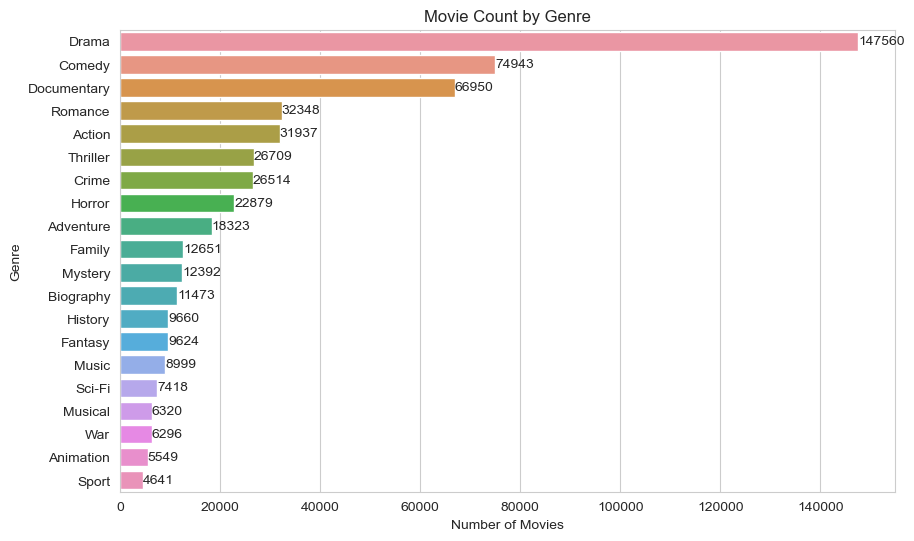

In [19]:
# Counting occurrences of each genre in the dataset

genre_counts = (movies['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else x).explode().value_counts()
).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)

# Adding the values to the graph
for i, count in enumerate(genre_counts.values):
    plt.text(count, i, str(count), ha='left', va='center')

plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Movie Count by Genre')
plt.show()

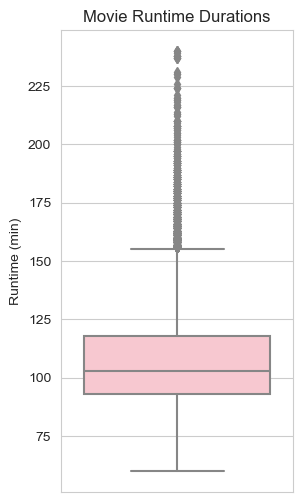

In [78]:
# Plotting the box plot of the runtime durations in my data
plt.figure(figsize=(3, 6))
sns.boxplot(data=movies, y='runtimeMinutes', color='pink')
plt.ylabel('Runtime (min)')
plt.title('Movie Runtime Durations')
plt.show()

/Users/iremnisa.kilinc/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


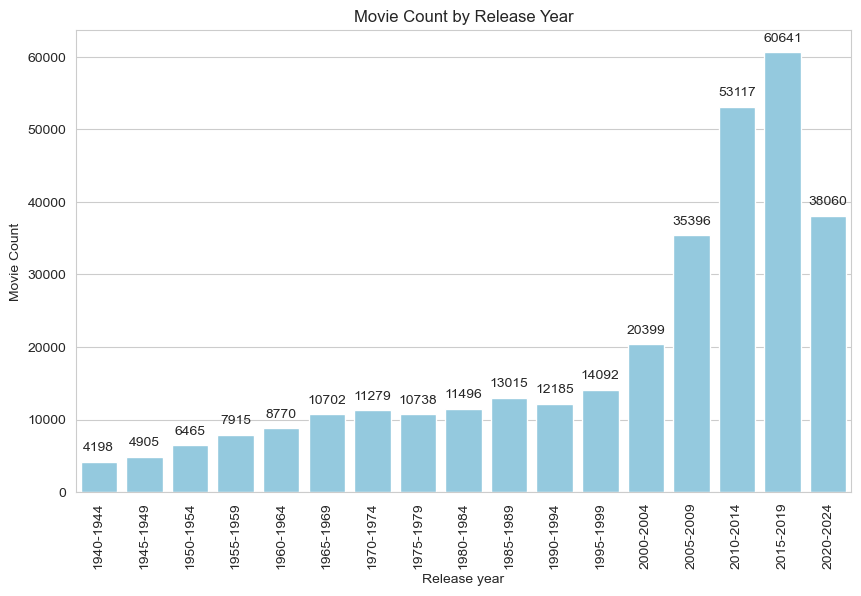

In [21]:
# Creating bins of 5 years in order to make it easier to read
bins = range(movies['startYear'].min(), movies['startYear'].max() + 6, 5)
labels = [f"{bin}-{bin + 4}" for bin in bins[:-1]]

# Plotting the count plot of Release Years with bins
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=movies, x=pd.cut(movies['startYear'], bins=bins, labels=labels), color='skyblue')

# Adding the values to the graph
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.ylabel('Movie Count')
plt.xlabel('Release year')
plt.title('Movie Count by Release Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [22]:
movies.shape

(324364, 6)

I still need to filter out movies to recommend. I will use the rating data to filter out the movie database.

## Cleaning Ratings Dataset

title.ratings.tsv.gz file contains the IMDb rating and votes information for titles

- tconst (string) - alphanumeric unique identifier of the title.
- averageRating – weighted average of all the individual user ratings.
- numVotes - number of votes the title has received.

In [23]:
ratings = pickle.load(open('title.ratings.pkl', 'rb'))

In [24]:
ratings.shape

(1427087, 3)

In [25]:
# removing movies that are not in my movies dataset
ratings = ratings[ratings['tconst'].isin(set(movies['tconst']))]

In [26]:
ratings.isna().sum()
#No NaN values! 

tconst           0
averageRating    0
numVotes         0
dtype: int64

In [27]:
ratings.describe()

,averageRating,numVotes
count,241765.000000,2.417650e+05
mean,6.137457,4.579765e+03
std,1.348796,4.069559e+04
min,1.000000,5.000000e+00
25%,5.300000,2.600000e+01
50%,6.200000,9.400000e+01
75%,7.100000,4.740000e+02
max,10.000000,2.883648e+06


In [28]:
ratings = ratings[(ratings['numVotes'] >= 1000) & (ratings['averageRating'] >= 5.5)]
# I removed low rated movies and movies with few ratings for relevancy and quality

/Users/iremnisa.kilinc/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


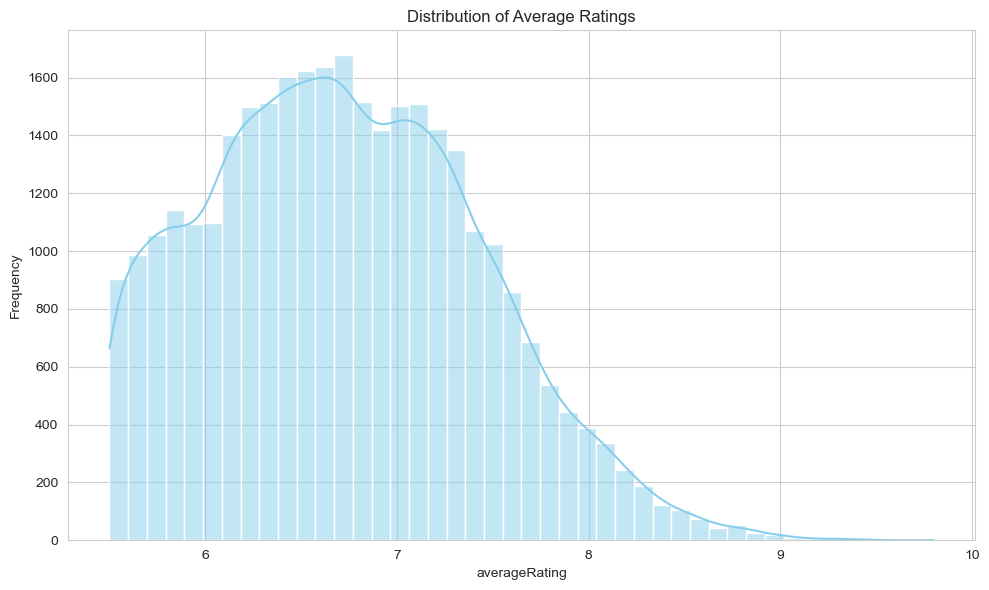

In [29]:
# Plot histogram for mean ratings
plt.figure(figsize=(10, 6))
sns.histplot(data=ratings, x='averageRating', color='skyblue', bins = 44, kde=True)
plt.ylabel('Frequency')
plt.title('Distribution of Average Ratings')

plt.tight_layout()
plt.show()

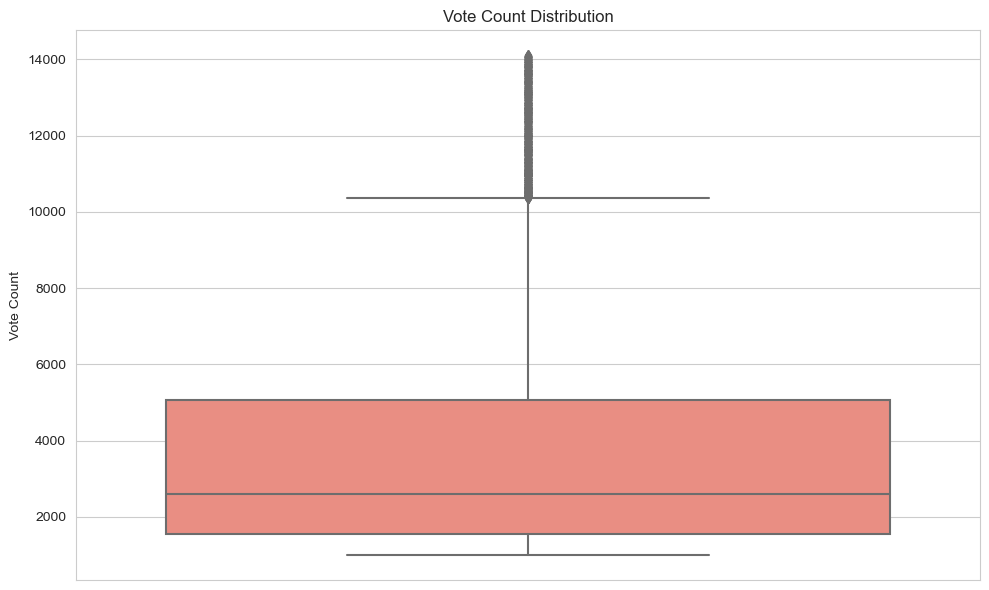

In [30]:
# Plot boxplot for rating counts up to P75 for easy interpretation

p75 = ratings['numVotes'].quantile(0.75)
plt.figure(figsize=(10, 6))
sns.boxplot(data=ratings[ratings['numVotes'] <= p75], y='numVotes', color='salmon')
plt.ylabel('Vote Count')
plt.title('Vote Count Distribution')

plt.tight_layout()
plt.show()

In [31]:
# # Plot histogram for mean ratings
# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=ratings, x='averageRating', color='skyblue', fill=True)
# plt.ylabel('Frequency')
# plt.title('Distribution of Average Ratings')

# plt.tight_layout()
# plt.show()

In [32]:
#plt.figure(figsize=(10, 6))
#sns.countplot(data=ratings, x='averageRating', color='skyblue')
#plt.ylabel('Frequency')
#plt.xlabel('Average Rating')
#plt.title('Distribution of Average Ratings')

#plt.tight_layout()
#plt.show()

In [33]:
ratings.shape

(32180, 3)

32180 movies seems logical for the purposes of my project. I will use this dataset for the foundation of my project. Let's dump it in a pickle file. 

In [34]:
ratings.reset_index(drop=True)
ratings.to_pickle('ratings.pkl')

### Filtering the movies according to number of votes and average rating

In [35]:
movies = movies[movies['tconst'].isin(set(ratings['tconst']))]

In [36]:
movies.shape

(32180, 6)

In [37]:
movies.reset_index(drop=True)

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0029284,My Favorite Wife,My Favorite Wife,1940,88,"Comedy,Romance"
1,tt0031359,Gaslight,Gaslight,1940,84,"Mystery,Thriller"
2,tt0031976,The Stars Look Down,The Stars Look Down,1940,110,Drama
3,tt0032179,21 Days Together,21 Days,1940,72,"Crime,Drama,Romance"
4,tt0032181,Abe Lincoln in Illinois,Abe Lincoln in Illinois,1940,110,"Biography,Drama,History"
...,...,...,...,...,...,...
32175,tt9907782,The Cursed,Eight for Silver,2021,111,"Fantasy,Horror,Mystery"
32176,tt9908390,Le lion,Le lion,2020,95,Comedy
32177,tt9911196,The Marriage Escape,De beentjes van Sint-Hildegard,2020,103,"Comedy,Drama"
32178,tt9916270,Il talento del calabrone,Il talento del calabrone,2020,84,Thriller


## Cleaning Cast DataFrame

title.principals.tsv.gz contains the principal cast/crew for titles

- tconst (string) - alphanumeric unique identifier of the title.
- ordering (integer) – a number to uniquely identify rows for a given titleId.
- nconst (string) - alphanumeric unique identifier of the name/person.
- category (string) - the category of job that person was in.
- job (string) - the specific job title if applicable, else "\N".
- characters (string) - the name of the character played if applicable, else "\N" (It is really "[role1,role2,....]" or "\N").


I only need the information on the cast members that appeared in the movies in my movies dataframe. So I will need to filter the people using movies dataframe. I will then check for NaN values and either drop them or fill them out using TMDB API if needed. 

In [39]:
principles = pickle.load(open('title.principals.pkl', 'rb'))

In [40]:
principles = principles[principles['tconst'].isin(set(movies['tconst']))]

In [41]:
principles.shape

(642182, 6)

In [42]:
#only keeping the cast because the crew data is stored elsewhere
principles = principles[principles['category'].isin(['actor', 'actress'])]

In [43]:
principles.drop(['characters','job'], axis=1, inplace=True)

In [44]:
missing_cast = movies[~movies['tconst'].isin(set(principles['tconst']))]
# We have 1430 movies without any cast information. Lets deep dive on them

In [45]:
missing_cast['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else x).explode().value_counts()

genres
Documentary    1408
Biography       342
Music           226
History         175
Crime           125
Sport           102
Comedy           89
Drama            81
War              35
Adventure        29
Family           22
News             19
Action           18
Mystery          14
Animation        14
Horror            8
Sci-Fi            7
Musical           6
Thriller          6
Fantasy           6
Romance           5
Western           3
Name: count, dtype: int64

These movies are mostly documentaries or biographies so it makes sense that they do not have cast information.

In [46]:
#Lets see the ratings of these movies before deciding on whether to drop them or not.
ratings[ratings['tconst'].
        isin(set(movies[~movies['tconst'].
                        isin(set(principles['tconst']))]['tconst']))].describe()

,averageRating,numVotes
count,1430.000000,1430.000000
mean,7.322727,5819.390909
std,0.592932,11490.730125
min,5.500000,1000.000000
25%,7.000000,1471.250000
50%,7.400000,2415.500000
75%,7.700000,5072.750000
max,9.400000,148645.000000


These movies seem to be relevant and popular so before deciding on dropping them.

In [47]:
# It is logical for Documentaries, Biographies, Animations and Music(?) to not have any cast. 
# Let's inspect the rest.
movies[(~movies['genres'].str.contains('Documentary|Biography|Music|Animation')) 
       & ~movies['tconst'].isin(set(principles['tconst']))]

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
48240,tt0049125,Davy Crockett and the River Pirates,Davy Crockett and the River Pirates,1956,81,"Adventure,Comedy,Drama"
53279,tt0054307,The Sign of Zorro,The Sign of Zorro,1958,91,"Adventure,Drama,Family"
60270,tt0061465,Chelsea Girls,Chelsea Girls,1966,210,Drama
62496,tt0063769,Seacrow Island,Vi på Saltkråkan,1968,95,"Comedy,Drama,Family"
76294,tt0077937,Mission Galactica: The Cylon Attack,Mission Galactica: The Cylon Attack,1979,108,"Action,Adventure,Sci-Fi"
91994,tt0094089,Swimming to Cambodia,Swimming to Cambodia,1987,85,"Comedy,Drama"
113758,tt0116447,Gray's Anatomy,Gray's Anatomy,1996,80,"Comedy,Drama"
135390,tt0139500,In Vanda's Room,No Quarto da Vanda,2000,171,Drama
992690,tt10045260,The Exorcist III: Legion,The Exorcist III: Legion,1990,105,"Horror,Mystery,Thriller"
1901392,tt11682998,White Latina,White Latina,2019,60,Comedy


I don't have to drop this data because I will use the cast data in corpus generation and it is not obligational for all data to be filled.

## Creating Genres DataFrame

Since our movies dataset has multiple genres for one movie, I will create a seperate genres dataset in order to analyze the data easily.

In [48]:
genres = movies.apply(lambda row: [(row['tconst'], genre) for genre in row['genres'].split(',')] if isinstance(row['genres'], str) else [], axis=1)
genres = pd.DataFrame([item for sublist in genres for item in sublist], columns=['tconst', 'genre'])

In [49]:
movies.drop(columns='genres',inplace=True)

/var/folders/_8/f5zjdbxn0vs8y_m3qv7n_8800000gn/T/ipykernel_10348/2635684754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies.drop(columns='genres',inplace=True)


In [76]:
movies.to_pickle('movies.pkl')

In [75]:
movies

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes
28768,tt0029284,My Favorite Wife,My Favorite Wife,1940,88
30799,tt0031359,Gaslight,Gaslight,1940,84
31405,tt0031976,The Stars Look Down,The Stars Look Down,1940,110
31600,tt0032179,21 Days Together,21 Days,1940,72
31602,tt0032181,Abe Lincoln in Illinois,Abe Lincoln in Illinois,1940,110
...,...,...,...,...,...
10698589,tt9907782,The Cursed,Eight for Silver,2021,111
10698877,tt9908390,Le lion,Le lion,2020,95
10700132,tt9911196,The Marriage Escape,De beentjes van Sint-Hildegard,2020,103
10702488,tt9916270,Il talento del calabrone,Il talento del calabrone,2020,84


In [51]:
genres.shape

(75089, 2)

In [52]:
genres.reset_index(drop=True)
genres.to_pickle('genres.pkl')

## Cleaning Crew DataFrame

title.crew.tsv.gz file contains the director and writer information for all the titles in IMDb. Fields include:

- tconst (string) - alphanumeric unique identifier of the title.
- directors (array of nconsts) - director(s) of the given title.
- writers (array of nconsts) – writer(s) of the given title.

I only need the information on the crew members that worked in the movies in my movies dataframe. So I will need to filter the people using movies dataframe. I will then check for NaN values and either drop them or fill them out using TMDB API if needed. 

In [53]:
crew = pickle.load(open('title.crew.pkl', 'rb'))

In [54]:
crew = crew[crew['tconst'].isin(set(movies['tconst']))]

In [55]:
crew.isna().any(axis=1).sum()

904

I need director and writer information for my recommender model because I believe that it is an important factor in choosing a movie. So I will use the TMDB API to fill out this information and if it is not available on TMDB, I will drop the row. 

In [56]:
def get_data(imdb_id):
    url = f"https://api.themoviedb.org/3/find/{imdb_id}?external_source=imdb_id"
    try:
        res = requests.get(url, headers=headers)
        results = res.json().get('movie_results', [])
        if results:
            tmdb_id = results[0]['id']
            api_url = f"https://api.themoviedb.org/3/movie/{tmdb_id}?append_to_response=credits"
            try:
                res = requests.get(api_url, headers=headers)
                response = res.json()
                return response
            except requests.exceptions.RequestException as e:
                print(f"Error processing URL {api_url}: {e}")
                return None
        else:
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error occurred: {e}")
        return None


In [57]:
def find_person_id(name_list):
    if not isinstance(name_list, list):
        name_list = [name_list]
        
    imdb_ids = []
    for name in name_list:
        url = f"https://api.themoviedb.org/3/search/person?query={name}&include_adult=false&language=en-US&page=1"
        try:
            res = requests.get(url, headers=headers).json()
            tmdb_id = res['results'][0]['id']
            url2 = f"https://api.themoviedb.org/3/person/{tmdb_id}/external_ids"
            try:
                res2 = requests.get(url2, headers=headers).json()
                imdb_id = res2['imdb_id']
                imdb_ids.append(imdb_id)
            except requests.exceptions.RequestException as e:
                print(f"Error occurred: {e}")
        except requests.exceptions.RequestException as e:
            print(f"Error occurred: {e}")
    return imdb_ids

In [58]:
def find_writers(response):
    crew_list = response['credits']['crew']
    writers = set()  
    for crew_member in crew_list:
        if (crew_member.get('department') == 'Writing') and (crew_member.get('job') in ['Screenplay', 'Story', 'Writer']):
            person_ids = find_person_id(crew_member['name'])
            if person_ids:
                writers.update(person_ids) 
                
    writers.discard(None) 
    if not writers:
        return None
    return ','.join(writers)


In [59]:
def find_directors(response):
    crew_list = response['credits']['crew']
    directors = set()  
    for crew_member in crew_list:
        if crew_member.get('job') in ['Director', 'Co director']:
            person_ids = find_person_id(crew_member['name'])
            if person_ids:
                directors.update(person_ids) 
                
    directors.discard(None) 
    if not directors:
        return None
    return ','.join(directors)


In [60]:
def fill_nan(df):
    
    for index, row in df.iterrows():
        if pd.isna(row['writers']) or pd.isna(row['directors']):
            
            movie_data = get_data(row['tconst'])
            if movie_data is not None:
                if pd.isna(row['directors']):
                    directors = find_directors(movie_data)
                    if directors is not None:
                        df.at[index, 'directors'] = directors
                if pd.isna(row['writers']):
                    writers = find_writers(movie_data)
                    if writers is not None:
                        df.at[index, 'writers'] = writers
            elif movie_data is None:
                df.drop(index, inplace=True)
                
    return df

In [61]:
fill_nan(crew)

,tconst,directors,writers
28800,tt0029284,nm0437717,"nm0818415,nm0818416,nm0564970,nm0437717,nm0565..."
30853,tt0031359,nm0225555,"nm0358096,nm0712653,nm0092658"
31467,tt0031976,nm0715346,"nm0188743,nm0930803,nm0178784"
31670,tt0032179,nm0212704,"nm0303335,nm0212704,nm0001294"
31672,tt0032181,nm0188669,"nm0792845,nm0428177"
...,...,...,...
10060305,tt9907782,nm1193346,nm1193346
10060594,tt9908390,nm1415268,"nm1597648,nm1597688"
10061808,tt9911196,nm0631590,"nm2063122,nm0277932,nm0495599,nm3547655"
10064086,tt9916270,nm1480867,"nm1480867,nm10538402"


In [62]:
crew.isna().sum()

tconst         0
directors      1
writers      750
dtype: int64

In [63]:
crew['writers'] = crew['writers'].fillna('')
crew['directors'] = crew['directors'].fillna('')

In [64]:
crew['directors'] = crew['directors'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else x)
crew['writers'] = crew['writers'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else x)

I will create a relations dataset to tie the movies data to the people data in another notebook for efficiency. This new dataset will combine the cast and crew data together. 

*(TMDB API data retrival and people dataset management tasks are hard to manage in one notebook at the same time)*

In [65]:
principles.reset_index(drop=True)
crew.reset_index(drop=True)

,tconst,directors,writers
0,tt0029284,{nm0437717},"{nm0565609, nm0818415, nm0564970, nm0855139, n..."
1,tt0031359,{nm0225555},"{nm0092658, nm0712653, nm0358096}"
2,tt0031976,{nm0715346},"{nm0930803, nm0188743, nm0178784}"
3,tt0032179,{nm0212704},"{nm0212704, nm0303335, nm0001294}"
4,tt0032181,{nm0188669},"{nm0428177, nm0792845}"
...,...,...,...
32140,tt9907782,{nm1193346},{nm1193346}
32141,tt9908390,{nm1415268},"{nm1597688, nm1597648}"
32142,tt9911196,{nm0631590},"{nm0277932, nm0495599, nm2063122, nm3547655}"
32143,tt9916270,{nm1480867},"{nm1480867, nm10538402}"


In [66]:
principles.to_pickle('cast.pkl')
crew.to_pickle('crew.pkl')

## Exporting datasets to MySQL

Since movies, ratings and genres datasets are cleaned up, I can export them directly from this notebook using sqlalchemy. I created a schema called recommender already and I will add my datasets as tables in this schema.

In [68]:
from sqlalchemy import create_engine
from getpass import getpass

In [69]:
password = getpass()

········


In [72]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost:3306'
engine = create_engine(connection_string)
conn =engine.connect() 

In [74]:
with engine.connect() as conn:    
    movies.to_sql(name='movies', con=engine, schema='recommender', if_exists='replace', index=False)
    ratings.to_sql(name='ratings', con=engine, schema='recommender', if_exists='replace', index=False)
    genres.to_sql(name='genres', con=engine, schema='recommender', if_exists='replace', index=False)